# Interactive dashboard for Sentinel-2 satellite imagery
---

## Overview

In this notebook, we will take a look at how to retrieve Sentinel-2 L2A satellite imagery from the [Microsoft Planetary Computer Data Catalog (MSPC)](https://planetarycomputer.microsoft.com/catalog). We will go over how to interact with the Data Catalog, which exposes a [SpatioTemporal Asset Catalog (STAC)](https://stacspec.org/en) interface for querying, searching and retrieving data. We will use the [stackstac](https://stackstac.readthedocs.io/en/latest/) package to load the data lazily, which means data is not *actually* read unless required (say, for plotting). Once loaded, we will process the data and make a simple interactive dashboard to look at the satellite imagery over a location for different seasons. We will use the [HoloViz ecosystem](https://holoviz.org/background.html) for the interactive dashboard.

# TODO: Add authorship using CITATION.cff

## Prerequisites

| Concepts | Importance | Notes |
|---|---|---|
|[Xarray](https://foundations.projectpythia.org/core/xarray.html)|Helpful|Background|
|[Dask + Xarray](https://foundations.projectpythia.org/core/xarray/dask-arrays-xarray.html)|Necessary|Background|
|[About the Microsoft Planetary Computer (MSPC)](https://planetarycomputer.microsoft.com/docs/overview/about/)|Helpful|Background|
|[Documentation of pystac-client](https://pystac-client.readthedocs.io/en/stable/)|Helpful|Consult as needed|
|[Landsat ML Cookbook](https://projectpythia.org/landsat-ml-cookbook/README.html)|Helpful|Similar cookbook, illustrates accessing Landsat data from MSPC|
|[About the HoloViz ecosystem](https://holoviz.org/background.html)|Helpful|How different HoloViz packages work with each other|
|[Sentinel-2 L2A User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2)|Necessary|Background about the satellite data|
|[Sentinel-2 L2A data definitions](https://sentinel.esa.int/documents/247904/685211/Sen2-Cor-L2A-Input-Output-Data-Definition-Document.pdf/e2dd6f01-c9c7-494d-a7f2-cd3be9ad891a?t=1506524754000)|Helpful|Section 2.3.10 has some useful information about the data we access in this cookbook|
- **Time to learn**: 15 minutes

## Imports

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
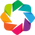

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
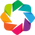

In [30]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import stackstac
import pystac_client
import planetary_computer
import panel as pn
import panel.widgets as pnw
import hvplot.xarray
import holoviews as hv
import geoviews as gv
from pystac.extensions.eo import EOExtension as eo
import datetime
from cartopy import crs
import dask
from dask.distributed import Client, LocalCluster
import odc.stac

xr.set_options(keep_attrs=True)
hv.extension('bokeh')
gv.extension('bokeh')

Since we will use dask to distribute our computation, we can explicitly create a dask cluster which would allow us to specify the required resources - for instance, how many workers are required, threads per worker, etc. For this recipe, we will create a [`LocalCluster`](https://docs.dask.org/en/stable/deploying-python.html#localcluster) on the machine where the notebook will be running with number of workers equal to the number of cpu-cores of the machine.

In [2]:
cluster = LocalCluster(n_workers=os.cpu_count())
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52353,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:52389,Total threads: 1
Dashboard: http://127.0.0.1:52393/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:52356,


# Open the catalog

The root of Microsoft Planetary Computer's STAC API endpoint is located at [https://planetarycomputer.microsoft.com/api/stac/v1](https://planetarycomputer.microsoft.com/api/stac/v1). We will load in the catalog using the `pystac_client.Client.open` method. Even though the STAC metadata in MSPC is publicly accessible, authentication is required to access the actual data. The `modifier` keyword can be used to explicitly "sign" an item, which basically means we can access the privately stored data (more information [here](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/#Manually-signing-assets)).

In [3]:
stac_root = 'https://planetarycomputer.microsoft.com/api/stac/v1'
catalog = pystac_client.Client.open(
    stac_root,
    modifier=planetary_computer.sign_inplace
)
print(f"{catalog.title} - {catalog.description}")

Microsoft Planetary Computer STAC API - Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


Let's search for any collections that have the substring "sentinel-2" in it to discover the sentinel-2 data.

In [4]:
sentinel2_collections = [collection for collection in catalog.get_collections() if "sentinel-2" in collection.id]
sentinel2_collections

[<CollectionClient id=sentinel-2-l2a>]

Looks like there is only one collection (`sentinel-2-l2a`) available in the catalog - which is the dataset we want to use.

# Query, Filter and Load the collection

Now that we have the ID of the collection of interest, we can specify certain filters to narrow down to exactly the data we want to look at. The final visualization in the recipe will look at how the NCAR Mesa Lab, Boulder CO looks like throughout the year as seen from space. To narrow down our search, we will use the following criteria -
- Bounding box: We will limit our spatial extent to the bounding box of the NCAR Mesa Lab region.
- Date range: We will look at the year 2022
- Collection: `sentinel-2-l2a` (from previous cell)
- Cloud threshold: Since cloud can block the satellite from making an observation of the ground, we will limit our search to satellite images where the cloud cover is less than a certain threshold, 40% in this case.

Feel free to change these filtering paramters to suit your needs when running in an interactive session.

In [5]:
bbox = [-105.283263,39.972809,-105.266569,39.987640] # NCAR, boulder, CO. bbox from http://bboxfinder.com/
date_range = "2021-01-01/2021-12-31"
collection = "sentinel-2-l2a"                        # full id of collection
cloud_thresh = 10

In [6]:
search = catalog.search(
    collections = sentinel2_collections,
    bbox = bbox,
    datetime = date_range,
    query={"eo:cloud_cover": {"lt": cloud_thresh}}
)
items = search.item_collection()
print(f"Found {len(items)} items in the {collection}")

Found 39 items in the sentinel-2-l2a


We now have an ItemCollection with the data that we need. Let's look at one of the items in the collection and explore what assets it has.

In [7]:
first_item = items.items[0]
all_bands = list(first_item.assets.keys())
print("Assets available:")
print(*all_bands, sep=', ')

Assets available:
AOT, B01, B02, B03, B04, B05, B06, B07, B08, B09, B11, B12, B8A, SCL, WVP, visual, preview, safe-manifest, granule-metadata, inspire-metadata, product-metadata, datastrip-metadata, tilejson, rendered_preview


Seems like there are a lot of assets associated with the item - you can read about them [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2). We are interested in the assets that start with a 'B', which are the bands associated with the different spectral bands in which the [MultiSpectral Instrument (MSI)](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument) of the satellite captures observations. Specifically, the RGB – or Red, Green and Blue - bands that we need to create a "True color" image are as follows:
|band|corresponds to|
|-|-|
|B04|Red|
|B03|Green|
|B02|Blue|

We will use the `stackstac.stack` function to load in the assets that start with the alphabet 'B'. This function will return a lazily-loaded `xr.DataArray` (using dask). 

In [8]:
?odc

Type:        module
String form: <module 'odc' (<_frozen_importlib_external.NamespaceLoader object at 0x1a96b2410>)>
Docstring:   <no docstring>

In [9]:
# bands_of_interest = [b for b in all_bands if b.startswith('B')]
bands_of_interest = ['B02', 'B03', 'B04']

# da = stackstac.stack(
#     items,
#     bounds_latlon=bbox,
#     assets=bands_of_interest,
#     chunksize='10MiB'
# ).compute()
# da
da = odc.stac.stac_load(
    items,
    bands=bands_of_interest,
    bbox=bbox,
    chunks={},  # <-- use Dask
).to_array(dim='band')
da

<xarray.DataArray (band: 3, time: 39, y: 166, x: 144)>
dask.array<stack, shape=(3, 39, 166, 144), dtype=float32, chunksize=(1, 1, 166, 144), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
  * x            (x) float64 4.758e+05 4.758e+05 ... 4.772e+05 4.772e+05
    spatial_ref  int32 32613
  * time         (time) datetime64[ns] 2021-01-06T17:57:29.024000 ... 2021-12...
  * band         (band) object 'B02' 'B03' 'B04'

## Prepare the data for visualization

On January 25th, 2022, the European Space Agency (data provider for Sentinel-2 satellite) made a change in their processing pipeline to address some issues that you can read about [here](https://sentinels.copernicus.eu/web/sentinel/-/copernicus-sentinel-2-major-products-upgrade-upcoming) if interested. For the purpose of this notebook, we will process the newer dataset such that it is harmonized with the old processing pipeline - in simple words, we will make sure that the data has the same statistical properties so that we can visualize them seamlessly.

In [10]:
# from https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Baseline-Change
def harmonize_to_old(data):  
    """
    Harmonize new Sentinel-2 data to the old baseline.

    Parameters
    ----------
    data: xarray.DataArray
        A DataArray with four dimensions: time, band, y, x

    Returns
    -------
    harmonized: xarray.DataArray
        A DataArray with all values harmonized to the old
        processing baseline.
    """
    cutoff = datetime.datetime(2022, 1, 25)
    offset = 1000
    bands = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]

    old = data.sel(time=slice(cutoff))

    to_process = list(set(bands) & set(data.band.data.tolist()))
    new = data.sel(time=slice(cutoff, None)).drop_sel(band=to_process)

    new_harmonized = data.sel(time=slice(cutoff, None), band=to_process).clip(offset)
    new_harmonized -= offset

    new = xr.concat([new, new_harmonized], "band").sel(band=data.band.data.tolist())
    return xr.concat([old, new], dim="time")

da = harmonize_to_old(da)
da

<xarray.DataArray (band: 3, time: 39, y: 166, x: 144)>
dask.array<stack, shape=(3, 39, 166, 144), dtype=float32, chunksize=(1, 1, 166, 144), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
  * x            (x) float64 4.758e+05 4.758e+05 ... 4.772e+05 4.772e+05
    spatial_ref  int32 32613
  * time         (time) datetime64[ns] 2021-01-06T17:57:29.024000 ... 2021-12...
  * band         (band) object 'B02' 'B03' 'B04'

Now that we have a harmonized dataset, we still need to process the data as follows:
- Sentinel-2 L2A provides the Surface Reflectance (SR) data, which usually ranges from 0 (no reflection) to 1.0 (complete reflection). However, the actual values in the loaded dataset ranges from 0 to ~10,000. These data values need to be scaled to 0.0-1.0 by dividing the data by 10,000. More details can be found in [section 2.3.10 of this document](https://sentinel.esa.int/documents/247904/685211/Sen2-Cor-L2A-Input-Output-Data-Definition-Document.pdf/e2dd6f01-c9c7-494d-a7f2-cd3be9ad891a?t=1506524754000).

We will then explicitly trigger the dask computation using the `compute()` method and load the result into memory. This is to reduce repeated calls to retrieve data from MSPC. By loading the processed  This wouldn't have been possible if the dataset was large.

In [11]:
# dask.visualize(da, optimize_graph=True)

In [12]:
da.max(dim='band').hvplot(x='x', y='y')

:DynamicMap   [time]
   :Image   [x,y]   (value)

In [24]:
da = da / 1e4   # Scale data values from 0:10000 to 0:1.0
da = da / da.max(dim='band')
da = da.compute()

We have now processed the data so that we can visualize it! *Note: The computation has not been done yet, it will be triggered as soon as we plot the data. This is possible because until now, `dask` has only created the "task graph" and we have not yet performed any operation that would trigger the computation yet*.

Let's create a function that will take a `time` input and have do the following tasks:
 1. plot an interactive RGB image of the data and overlay it on a map of the world.
 2. provide a [date slider widget](https://panel.holoviz.org/reference/widgets/DateSlider.html) which can be used to interact with the plot.
 3. only set the default value of the date slider to the `time`, but allow the user to slide through the length of the entire dataset.

In [41]:
xr.where(np.isnan(da.sel(band=['B04', 'B03', 'B02'])), 1, 0).hvplot(x='x', y='y')

:DynamicMap   [band,time]
   :Image   [x,y]   (value)

In [37]:
season_names = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

def rgb_during(time):
    da_rgb = da.sel(band=['B04', 'B03', 'B02'])
    start_date = pd.to_datetime(da_rgb['time'].min().data).to_pydatetime()
    end_date = pd.to_datetime(da_rgb['time'].max().data).to_pydatetime()
    closest_date = pd.to_datetime(da_rgb.sel(time=time, method='nearest').time.data).to_pydatetime()
    dt_slider = pnw.DateSlider(name='Date', start=start_date, end=end_date, value=closest_date)
    
    def get_obs_on(t):
        season_key = [month%12 // 3 + 1 for month in range(1, 13)][t.month-1]
        season = season_names[season_key]
        alpha = xr.where(np.isnan(da_rgb), 1, 0)
        # return da_rgb.sel(time=t, method='nearest').hvplot.rgb(x='x', y='y', bands='band', alpha=alpha, geo=True, tiles='ESRI', rasterize=True, title=f"{season}: {t.strftime('%Y-%m-%d')}")
        return xr.concat(
            da.sel(band=['B04', 'B03', 'B02']).sel(time=t, method='nearest').transpose('y', 'x', 'band'), 
            alpha.
            .hvplot.rgb(x='x', y='y', bands='band', geo=True, tiles='ESRI', crs=crs.epsg(items[0].properties['proj:epsg']), rasterize=True, title=f"{season}: {t.strftime('%Y-%m-%d')}", alpha=alpha)
        # return da.sel(band=['B04', 'B03', 'B02']).sel(time=t, method='nearest').hvplot.rgb(x='x', y='y', bands='band', geo=True, tiles='ESRI', crs=crs.epsg(items[0].properties['proj:epsg']), rasterize=True, title=f"{season}: {t.strftime('%Y-%m-%d')}")
    
    return pn.panel(pn.Column(
                pn.bind(get_obs_on, t=dt_slider), 
                pn.Row(
                    pn.Spacer(width=60),
                    dt_slider,
                )
            ))

In [38]:
rgb_during('2023-01-01')

/Users/pdas47/conda/envs/cookbook-dev/lib/python3.11/site-packages/holoviews/plotting/bokeh/raster.py:191: RuntimeWarning: invalid value encountered in cast
  img = img.astype(np.uint8)


AbbreviatedException: RuntimeError: 

Expected global_alpha to reference fields in the supplied data source.

When a 'source' argument is passed to a glyph method, values that are sequences
(like lists or arrays) must come from references to data columns in the source.

For instance, as an example:

    source = ColumnDataSource(data=dict(x=a_list, y=an_array))

    p.circle(x='x', y='y', source=source, ...) # pass column names and a source

Alternatively, *all* data sequences may be provided as literals as long as a
source is *not* provided:

    p.circle(x=a_list, y=an_array, ...)  # pass actual sequences and no source



To view the original traceback, catch this exception and call print_traceback() method.

Column
    [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] Row
        [0] Spacer(width=60)
        [1] DateSlider(end=datetime.datetime(2021, ..., name='Date', start=datetime.datetime(2021, ..., value=datetime.datetime(2021, ...)

Let's now compose a dashboard using `panel`.

In [19]:
da

<xarray.DataArray (band: 3, time: 39, y: 166, x: 144)>
array([[[[0.74820143, 0.1415929 , 0.00694444, ..., 0.4852273 ,
          0.51905835, 0.4798942 ],
         [0.35051546, 0.00645161, 0.00595238, ..., 0.51483315,
          0.4937853 , 0.45595855],
         [0.0070922 , 0.00649351, 0.00578035, ..., 0.4532374 ,
          0.4827586 , 0.47256097],
         ...,
         [0.00649351, 0.01      , 0.00763359, ..., 0.5605263 ,
          0.2857143 , 0.24465558],
         [0.04761905, 1.        , 0.02040816, ..., 0.34391537,
          0.22198276, 0.5528634 ],
         [0.00877193, 0.01639344, 0.04      , ..., 0.21084337,
          0.32108626, 0.5938748 ]],

        [[       nan,        nan,        nan, ..., 0.52834463,
          0.55656105, 0.51554406],
         [       nan,        nan,        nan, ..., 0.5376671 ,
          0.51752335, 0.48618492],
         [       nan,        nan,        nan, ..., 0.5164474 ,
          0.5026738 , 0.4867947 ],
...
         [0.8342246 , 1.        , 0.9500001 , ..., 1.        ,
          1.        , 1.        ],
         [0.6066351 , 0.61797756, 1.        , ..., 1.        ,
          1.        , 1.        ],
         [0.60126585, 0.5       , 0.5       , ..., 1.        ,
          1.        , 1.        ]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ..., 1.        ,
          1.        , 1.        ],
         [       nan,        nan,        nan, ..., 1.        ,
          1.        , 1.        ],
         [       nan,        nan,        nan, ..., 1.        ,
          1.        , 1.        ]]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
  * x            (x) float64 4.758e+05 4.758e+05 ... 4.772e+05 4.772e+05
    spatial_ref  int32 32613
  * time         (time) datetime64[ns] 2021-01-06T17:57:29.024000 ... 2021-12...
  * band         (band) object 'B02' 'B03' 'B04'

In [20]:
winter = '2021-01-15'


da.sel(band='B04').isel(time=0).hvplot(x='x', y='y', data_aspect=1, cmap='Blues') \
+ da.sel(band='B03').isel(time=0).hvplot(x='x', y='y', data_aspect=1, cmap='Greens') \
+ da.sel(band='B02').isel(time=0).hvplot(x='x', y='y', data_aspect=1, cmap='Reds')

:Layout
   .Image.I   :Image   [x,y]   (value)
   .Image.II  :Image   [x,y]   (value)
   .Image.III :Image   [x,y]   (value)

In [21]:
winter = '2021-01-15'
spring = '2021-04-15'
summer = '2021-08-01'
fall = '2021-09-15'

winter_plot = rgb_during(winter)
spring_plot = rgb_during(spring)
summer_plot = rgb_during(summer)
fall_plot = rgb_during(fall)

pn.Column(
    pn.Row(winter_plot, spring_plot),
    pn.Row(summer_plot, fall_plot)
)

/Users/pdas47/conda/envs/cookbook-dev/lib/python3.11/site-packages/holoviews/plotting/bokeh/raster.py:191: RuntimeWarning: invalid value encountered in cast
  img = img.astype(np.uint8)
/Users/pdas47/conda/envs/cookbook-dev/lib/python3.11/site-packages/holoviews/plotting/bokeh/raster.py:191: RuntimeWarning: invalid value encountered in cast
  img = img.astype(np.uint8)


Column
    [0] Row
        [0] Column
            [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
            [1] Row
                [0] Spacer(width=60)
                [1] DateSlider(end=datetime.datetime(2021, ..., name='Date', start=datetime.datetime(2021, ..., value=datetime.datetime(2021, ...)
        [1] Column
            [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
            [1] Row
                [0] Spacer(width=60)
                [1] DateSlider(end=datetime.datetime(2021, ..., name='Date', start=datetime.datetime(2021, ..., value=datetime.datetime(2021, ...)
    [1] Row
        [0] Column
            [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
            [1] Row
                [0] Spacer(width=60)
                [1] DateSlider(end=datetime.datetime(2021, ..., name='Date', start=datetime.datetime(2021, ..., value=datetime.datetime(2021, ...)
        [1] Column
            [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
            [1] Row
                [0] Spacer(width=60)
                [1] DateSlider(end=datetime.datetime(2021, ..., name='Date', start=datetime.datetime(2021, ..., value=datetime.datetime(2021, ...)

---
## Summary
In this recipe, we looked at how to access Sentinel-2 satellite data over a region of interest and create an interactive dashboard to visualize the data.

### What's next?
We plotted the RGB or True color image of our region of interest using a subset of all the bands available. We can further calculate useful indices, such as the [Normalized Difference Snow Index (NDSI)](https://nsidc.org/data/user-resources/help-center/what-ndsi-snow-cover-and-how-does-it-compare-fsc) or the [Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index).

## Resources and references
- Authored by Pritam Das ([@pritamd47](https://github.com/pritamd47)), June 2023 during Project Pythia cookoff 2023.
- This notebook takes a lot of inspiration from the [Landsat ML Cookbook](https://github.com/ProjectPythia/landsat-ml-cookbook/) by Demetris Roumis.
- This notebook uses concepts and code illustrated in the [Reading Data from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/).